## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # for nice progress bars
import math # plots
np.random.seed(20030403)



In [3]:
np.random.seed(20030403)
np.set_printoptions(precision=2) # 2 decimal places for numpy

## Datasets

In [4]:
square_simple_train = pd.read_csv('../regression/square-simple-training.csv')
steps_small_train = pd.read_csv('../regression/steps-small-training.csv')
multimodal_large_train = pd.read_csv('../regression/multimodal-large-training.csv')

square_simple_test = pd.read_csv('../regression/square-simple-training.csv')
steps_small_test = pd.read_csv('../regression/steps-small-training.csv')
multimodal_large_test = pd.read_csv('../regression/multimodal-large-training.csv')


## Helper Functions and classes

In [5]:
def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def sigmoidal(x, derivative=False):
    x_safe = np.clip(x, -500, 500) # aby nie bylo overflow
    s = 1 / (1 + np.exp(-x_safe))
    if derivative:
        return s * (1 - s)
    return s

def linear(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    return x

In [6]:
def plot_data(data_x, data_y):
    plt.figure(figsize=(8, 6))
    plt.scatter(data_x, data_y, color='blue', label='Dane treningowe')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Wykres danych treningowych")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.sd = None
    
    def fit(self, data): # Compute the mean and standard deviation along the feature axis (axis=0)
        self.mean = np.mean(data, axis=0)
        self.sd = np.std(data, axis=0)
    
    def transform(self, data): # Scale the data using the computed mean and sd
        return (data - self.mean) / self.sd
    
    def fit_transform(self, data): # Fit to the data, then transform it
        self.fit(data)
        return self.transform(data)
    
    def inverse_transform(self, data): # reverse the scaling
        return data * self.sd + self.mean

# Data plots

## square_simple_train

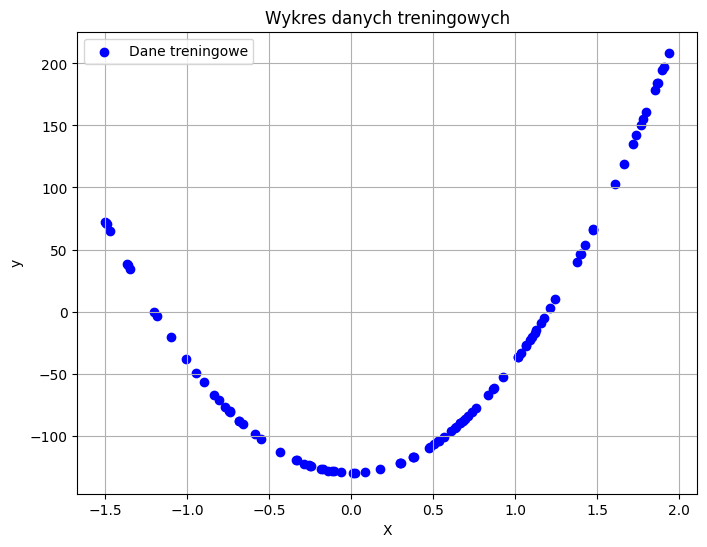

In [8]:
plot_data(square_simple_train['x'], square_simple_train['y'])

## steps_small_train

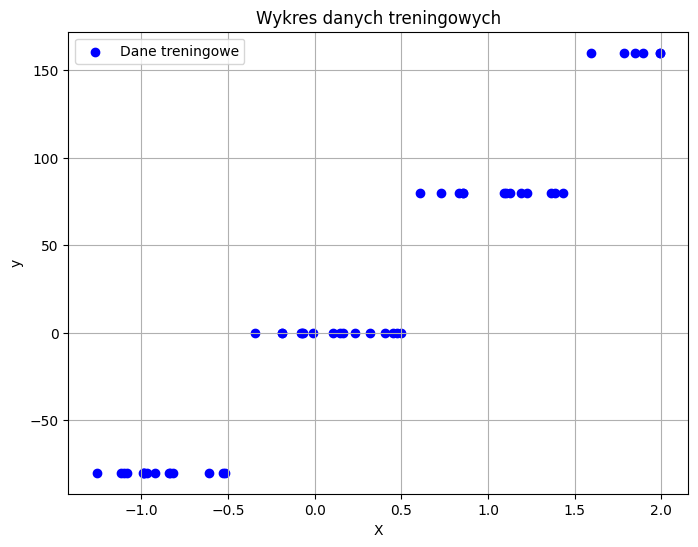

In [9]:
plot_data(steps_small_train['x'], steps_small_train['y'])

## multimodal_large_train

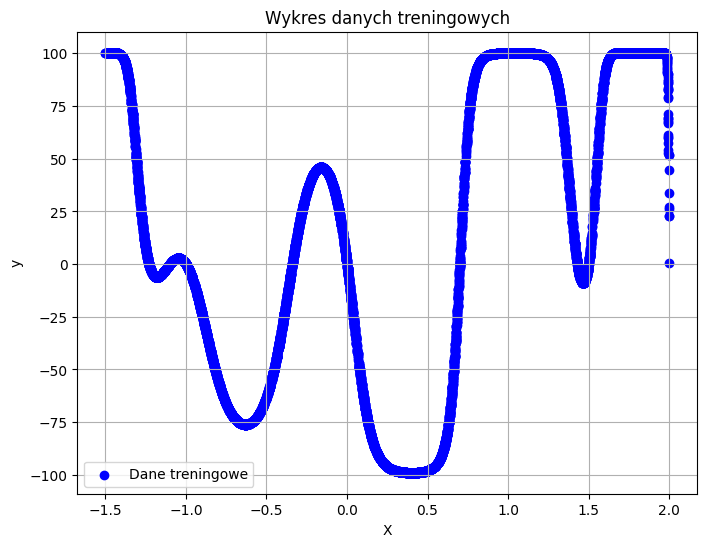

In [10]:
plot_data(multimodal_large_train['x'], multimodal_large_train['y'])

# MLP backprop

In [11]:
class MLPBackprop:
    def __init__(self, layers, hidden_activation_function='sigmoid', output_activation_function='sigmoid', starting_weights=None, starting_biases=None):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.print_epoch = True
        self.weight_history = []
        self.bias_history = []
        activation_functions = {"relu": relu, "sigmoid": sigmoidal, "linear": linear}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Invalid hidden activation function, choose from:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Invalid output activation function, choose from:", activation_functions)
        
        for i in range(len(self.layers) - 1): # ustaw pocz. wagi
            n_input = self.layers[i]
            n_output = self.layers[i + 1]

            # funk. aktywacji ost. warsty aktywacji moze byc inna
            activation_function = self.hidden_activation_function if i < len(self.layers) - 2 else self.output_activation_function
            
            if activation_function == sigmoidal: # Xavier initialization 
                weight_matrix = np.random.normal(0, np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
            elif activation_function == relu: # He initialization
                weight_matrix = np.random.uniform(0, np.sqrt(2 / n_input), size=(n_input, n_output))
            else:
                weight_matrix = np.random.randn(n_input, n_output)
            self.weights.append(weight_matrix)
            
            self.biases.append(np.zeros((1, n_output)))
    
    def forward(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.activations = [X]
        activation = X
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = self.hidden_activation_function(z)
            self.activations.append(activation)
            
        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        output = self.output_activation_function(z)
        
        return output
    
    def predict(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        return self.forward(X)
    
    def backpropagation(self, X, y, learning_rate=0.01):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(-1, 1)
        
        N = X.shape[0]
        output = self.forward(X)
        
        d_loss = (output - y) / N
        deltas = [d_loss]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.hidden_activation_function(self.activations[i], derivative=True)
            deltas.append(delta)
        
        deltas.reverse()
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * np.dot(self.activations[i].T, deltas[i])
            self.biases[i] -= learning_rate * np.sum(deltas[i], axis=0, keepdims=True)

        current_weights = [w.copy() for w in self.weights]
        current_biases = [b.copy() for b in self.biases]
        self.weight_history.append(current_weights)
        self.bias_history.append(current_biases)

    def train(self, X, y, epochs=1000, learning_rate=0.02, batch_size=0):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(-1, 1)
        
        best_loss = np.inf
        best_weights = None
        best_biases = None

        progress_bar = tqdm(range(epochs), desc="Training")

        for epoch in progress_bar:
            if batch_size == 0:
                self.backpropagation(X, y, learning_rate)
            else:
                indices = np.random.permutation(X.shape[0])
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                for i in range(0, X.shape[0], batch_size):
                    X_batch = X_shuffled[i:i + batch_size]
                    y_batch = y_shuffled[i:i + batch_size]
                    self.backpropagation(X_batch, y_batch, learning_rate)
            
            predictions = self.predict(X)
            loss = np.mean(np.square(y - predictions))
            
            if loss < best_loss:
                best_loss = loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
            
            progress_bar.set_postfix(loss=f"{loss:.6f}")
        
        self.weights = best_weights
        self.biases = best_biases
        print(f'Best loss: {best_loss}')

    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def plot_history(self, figsize=(15, 10), save_path=None, max_neurons_per_plot=10):
        
        if not self.weight_history:
            raise ValueError("Brak historii wag. Wykonaj najpierw trenowanie sieci.")
        
        num_layers = len(self.weights)
        num_epochs = len(self.weight_history)
        epochs = np.arange(num_epochs)
        
        # Oblicz całkowitą liczbę podwykresów (jeden dla wag i jeden dla biasów każdej warstwy)
        total_subplots = num_layers * 2
        
        # Oblicz optymalny układ podwykresów
        cols = min(2, total_subplots)
        rows = math.ceil(total_subplots / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
        # Spłaszcz tablicę axes dla łatwiejszego indeksowania
        if total_subplots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        subplot_idx = 0
        
        # Dla każdej warstwy
        for layer_idx in range(num_layers):
            # Pobierz wymiary wag dla tej warstwy
            input_size, output_size = self.weights[layer_idx].shape
            
            # Przygotuj wykres dla wag
            ax_weights = axes[subplot_idx]
            subplot_idx += 1
            
            # Jeśli liczba wag jest zbyt duża, wybierz losową próbkę
            total_weights = input_size * output_size
            if total_weights > max_neurons_per_plot:
                # Wybierz losowe indeksy wag do pokazania
                indices_flat = np.random.choice(total_weights, max_neurons_per_plot, replace=False)
                # Konwertuj indeksy płaskie na pary (i, j)
                indices = [(idx // output_size, idx % output_size) for idx in indices_flat]
            else:
                # Pokaż wszystkie wagi
                indices = [(i, j) for i in range(input_size) for j in range(output_size)]
            
            # Dla każdej wybranej wagi narysuj linię
            for i, j in indices:
                weight_values = [self.weight_history[epoch][layer_idx][i, j] for epoch in range(num_epochs)]
                ax_weights.plot(epochs, weight_values, '-', linewidth=1, 
                            label=f'w_{i+1},{j+1}' if total_weights <= 20 else None)
            
            ax_weights.set_title(f'Warstwa {layer_idx+1}: Wagi')
            ax_weights.set_xlabel('Epoka')
            ax_weights.set_ylabel('Wartość wagi')
            ax_weights.grid(True, alpha=0.3)
            if total_weights <= 20:  # Pokaż legendę tylko gdy liczba wag jest mała
                ax_weights.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            # Przygotuj wykres dla biasów
            ax_biases = axes[subplot_idx]
            subplot_idx += 1
            
            # Dla każdego biasu narysuj linię
            bias_size = self.biases[layer_idx].shape[1]
            
            # Jeśli liczba biasów jest zbyt duża, wybierz losową próbkę
            if bias_size > max_neurons_per_plot:
                bias_indices = np.random.choice(bias_size, max_neurons_per_plot, replace=False)
            else:
                bias_indices = range(bias_size)
            
            for j in bias_indices:
                bias_values = [self.bias_history[epoch][layer_idx][0, j] for epoch in range(num_epochs)]
                ax_biases.plot(epochs, bias_values, '-', linewidth=1, 
                            label=f'b_{j+1}' if bias_size <= 20 else None)
            
            ax_biases.set_title(f'Warstwa {layer_idx+1}: Biasy')
            ax_biases.set_xlabel('Epoka')
            ax_biases.set_ylabel('Wartość biasu')
            ax_biases.grid(True, alpha=0.3)
            if bias_size <= 20:  # Pokaż legendę tylko gdy liczba biasów jest mała
                ax_biases.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Ukryj puste podwykresy, jeśli takie istnieją
        for i in range(subplot_idx, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

# Scaler

# Testing on data

In [12]:
def plot_comparison(X_test, y_test, y_pred):
    plt.scatter(X_test, y_test, label="True Data")
    plt.scatter(X_test, y_pred, label="Predicted Data")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()

## square_simple_train

Training: 100%|██████████| 20000/20000 [00:31<00:00, 637.43it/s, loss=0.448036]


Best loss: 0.0006101555677972182
MSE: 5.59718347045216


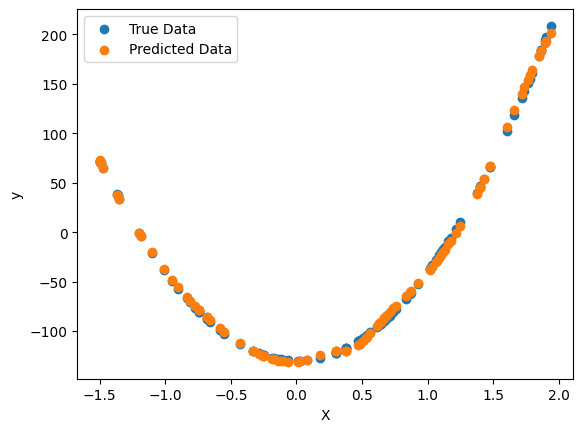

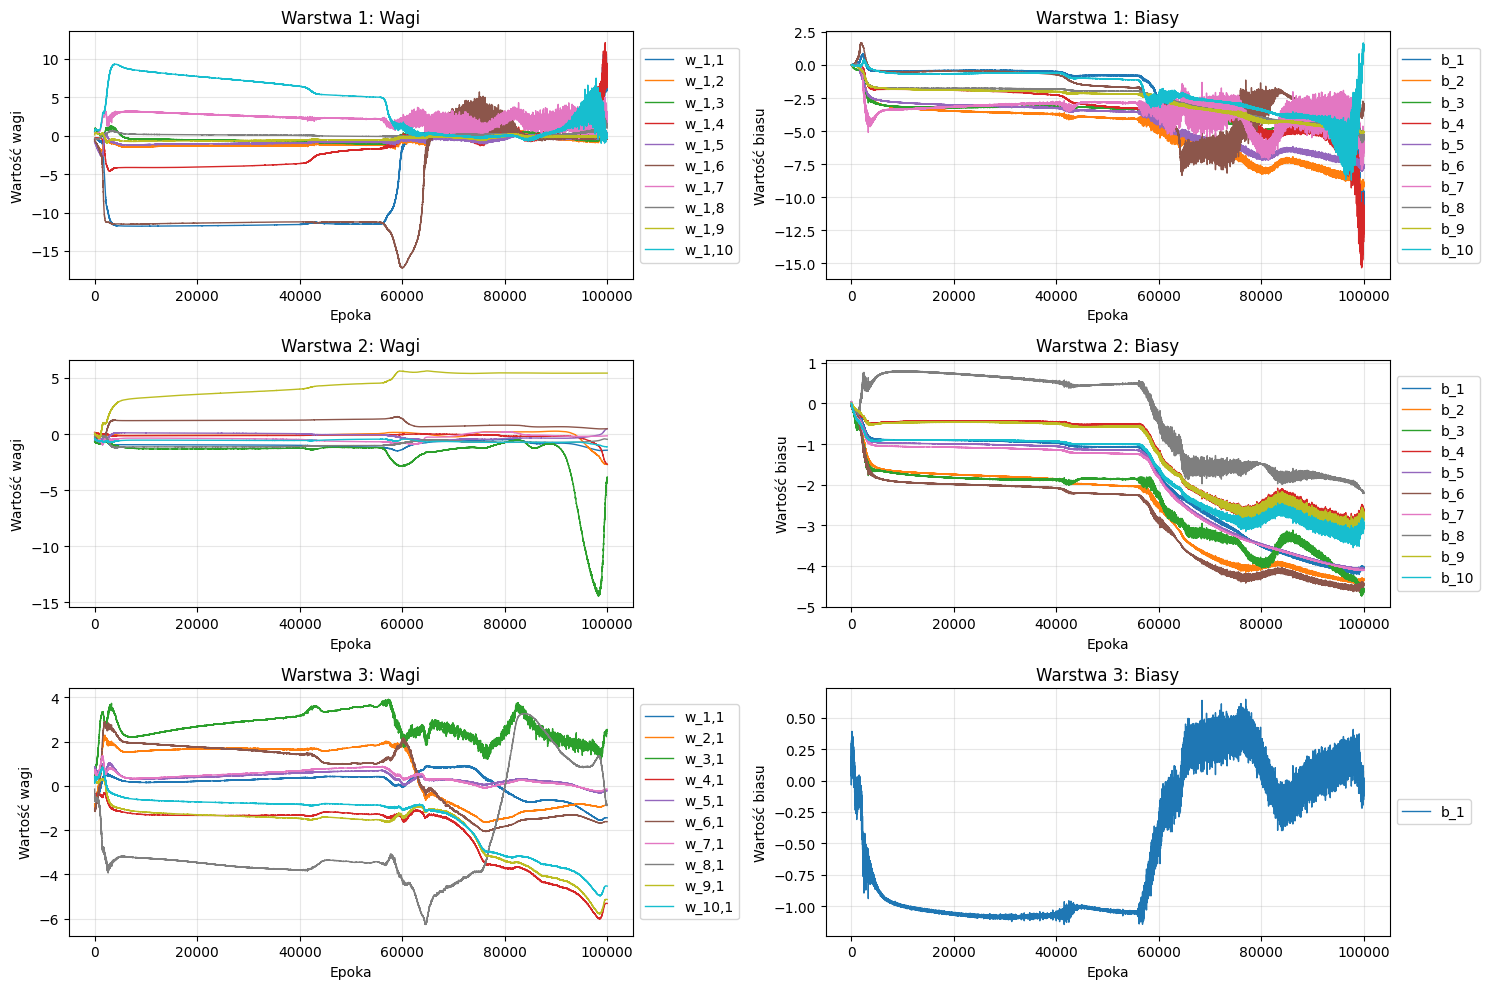

In [14]:
X_train = square_simple_train.iloc[:, 1].values.reshape(-1, 1)
y_train = square_simple_train.iloc[:, 2].values.reshape(-1, 1)
X_test = square_simple_test.iloc[:, 1].values.reshape(-1, 1)
y_test = square_simple_test.iloc[:, 2].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

NN = MLPBackprop([1, 10, 10, 1], output_activation_function = 'linear')
NN.train(X_train_scaled, y_train_scaled, epochs=20000, batch_size=20, learning_rate=0.30)
# NN.train(X_train_scaled, y_train_scaled, epochs=1000, batch_size=10, learning_rate=0.05)

# Inne DOBRE MSE:
# 2
# NN = MLPBackprop([1, 10, 10, 1])
# NN.train(X_train_scaled, y_train_scaled, epochs=20000, batch_size=20, learning_rate=0.35)

# MSE: 0.6398350970693834
# NN = MLPBackprop([1, 8, 8, 1])
# NN.train(X_train_scaled, y_train_scaled, epochs=20000, batch_size=15, learning_rate=0.15)

y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)

NN.plot_history()


## Steps small

preparing the data

Training: 100%|██████████| 5000/5000 [00:06<00:00, 784.28it/s, loss=0.036144]


Best loss: 0.035550034910900294
MSE: 227.5202234297618


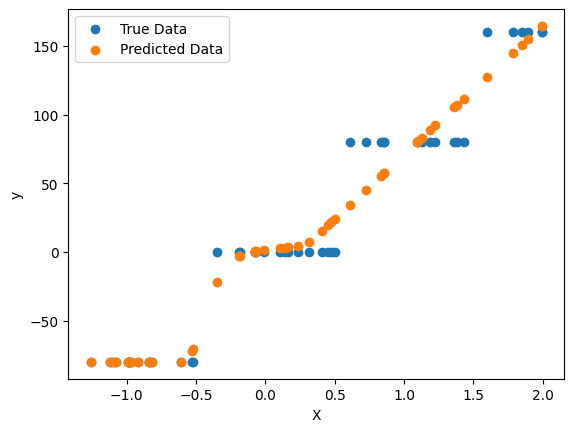

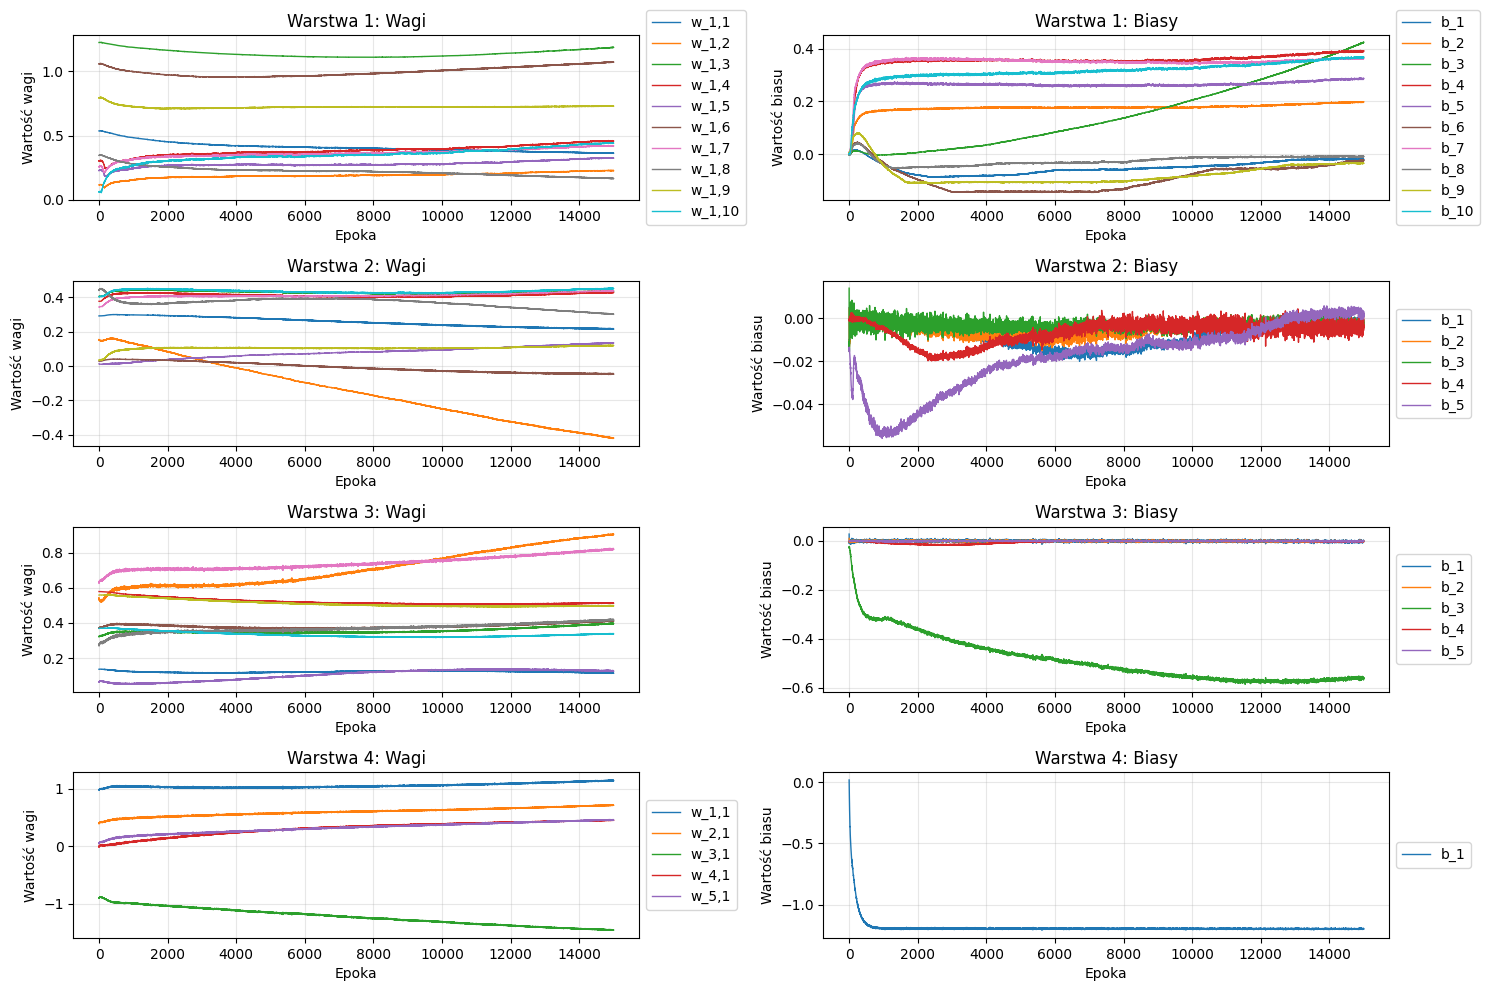

In [16]:
X_train = steps_small_train.iloc[:, 1:2].values
y_train = steps_small_train.iloc[:, -1].values
X_test = steps_small_test.iloc[:, 1:2].values
y_test = steps_small_test.iloc[:, -1].values

X_train = steps_small_train.iloc[:, 1].values.reshape(-1, 1)
y_train = steps_small_train.iloc[:, 2].values.reshape(-1, 1)
X_test = steps_small_test.iloc[:, 1].values.reshape(-1, 1)
y_test = steps_small_test.iloc[:, 2].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)


NN = None
NN = MLPBackprop([1, 10, 5, 5, 1], hidden_activation_function="relu", output_activation_function="linear")

NN.train(X_train_scaled, y_train_scaled, epochs=5000, learning_rate=0.05, batch_size=20)
y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)

NN.plot_history()

## Multimodal large

Training: 100%|██████████| 1000/1000 [01:21<00:00, 12.22it/s, loss=0.780972]


Best loss: 0.7217609119033341
MSE: 3736.757002217634


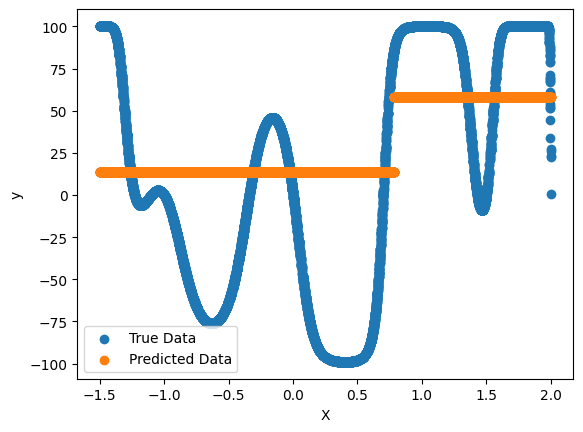

In [40]:
X_train = multimodal_large_train.iloc[:, 0:1].values
y_train = multimodal_large_train.iloc[:, -1].values
X_test = multimodal_large_test.iloc[:, 0:1].values
y_test = multimodal_large_test.iloc[:, -1].values


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)


NN = MLPBackprop([1, 10, 10, 10, 1], hidden_activation_function='sigmoid', output_activation_function='sigmoid')
NN.train(X_train_scaled, y_train_scaled, epochs=1000, learning_rate=0.2, batch_size=20)


y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)



Training: 100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s, loss=0.999997]


Best loss: 0.9972148074618915
MSE: 5162.858438359716


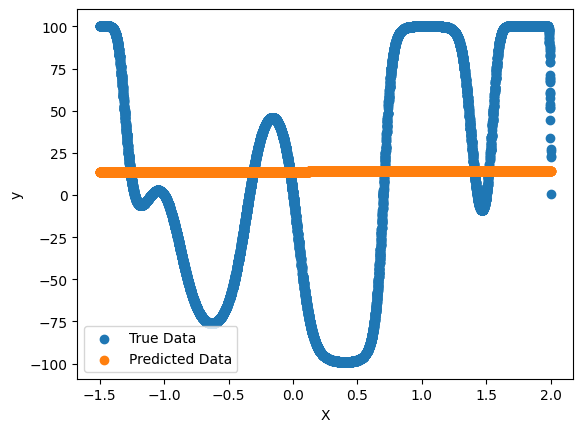

In [51]:
X_train = multimodal_large_train.iloc[:, 0:1].values
y_train = multimodal_large_train.iloc[:, -1].values
X_test = multimodal_large_test.iloc[:, 0:1].values
y_test = multimodal_large_test.iloc[:, -1].values


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_test)

X_test_scaled = scaler_X.transform(X_test)


NN = MLPBackprop([1, 10, 10, 10, 1], hidden_activation_function='sigmoid', output_activation_function='sigmoid')
NN.train(X_train_scaled, y_train_scaled, epochs=1000, learning_rate=0.2, batch_size=20)


y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)


[1, 10, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s, loss=0.763690]


Best loss: 0.2062562703886796
MSE: 1067.8460829829703


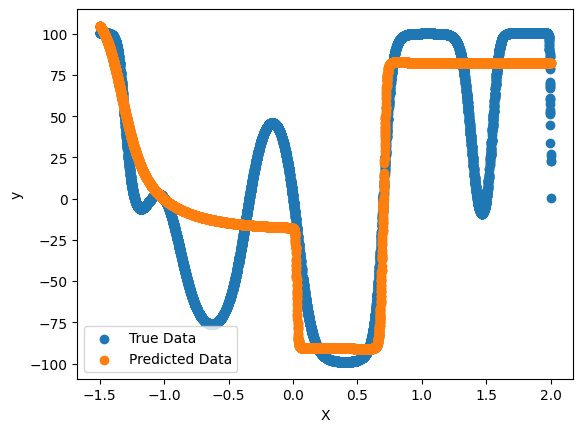

[1, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s, loss=0.385100]


Best loss: 0.20279041572694115
MSE: 1049.9023893548867


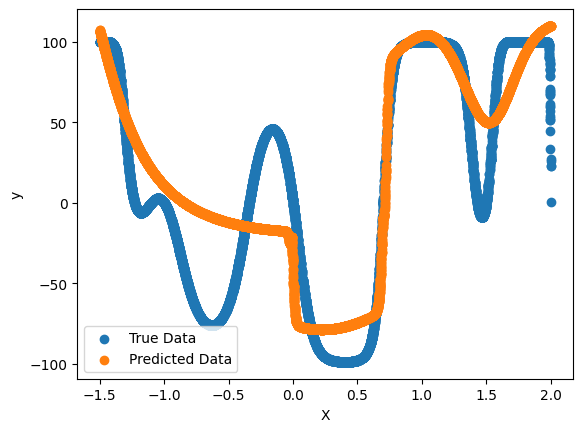

[1, 5, 10, 5, 1]


Training: 100%|██████████| 1000/1000 [01:14<00:00, 13.39it/s, loss=0.975219]


Best loss: 0.2900900047756673
MSE: 1501.8766446637414


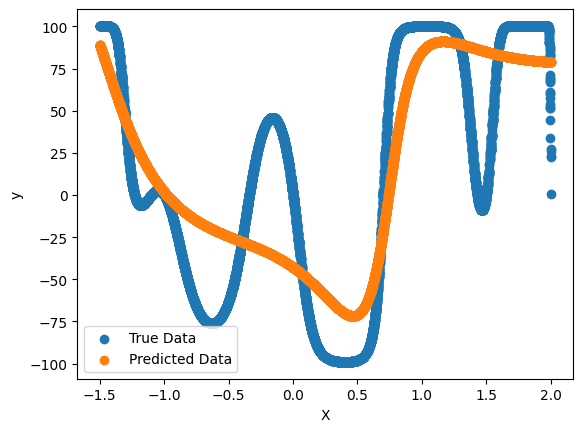

[1, 5, 5, 5, 1]


Training: 100%|██████████| 1000/1000 [01:10<00:00, 14.20it/s, loss=0.452700]


Best loss: 0.1807246078337151
MSE: 935.6615641802963


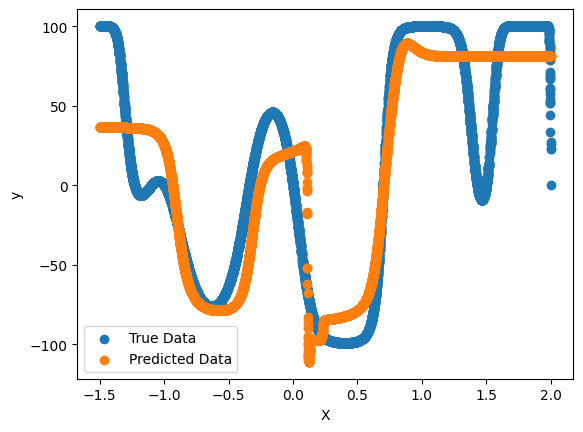

[1, 5, 10, 1]


Training: 100%|██████████| 1000/1000 [00:54<00:00, 18.33it/s, loss=0.533721]


Best loss: 0.08708827457070611
MSE: 450.88022147799916


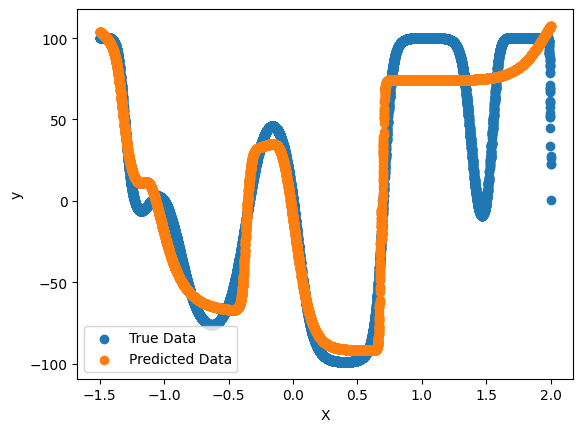

In [44]:
architectures = [
[1, 10, 10, 10, 1],
[1, 10, 10, 1],
[1, 5, 10, 5, 1],
[1, 5, 5, 5, 1],
[1, 5, 10, 1]
]

for architecture in architectures:
    print(architecture)
    NN = MLPBackprop(architecture, hidden_activation_function='sigmoid', output_activation_function='linear')
    NN.train(X_train_scaled, y_train_scaled, epochs=1000, learning_rate=0.2, batch_size=20)


    y_pred_scaled = NN.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
    print("MSE:", mse)

    plot_comparison(X_test, y_test, y_pred)


[1, 10, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s, loss=0.261119]


Best loss: 0.14930420985674217
MSE: 772.9894241176004


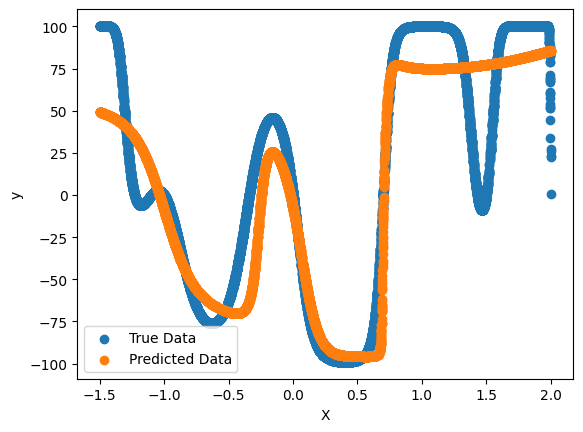

[1, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s, loss=0.273468]


Best loss: 0.11249787216395903
MSE: 582.4327760209318


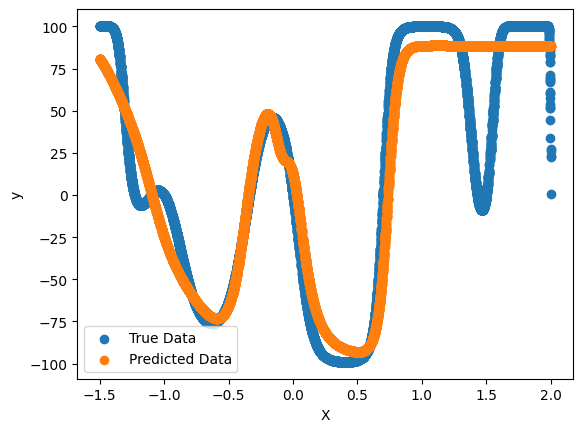

[1, 5, 10, 5, 1]


Training: 100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s, loss=0.720603]


Best loss: 0.30822286100637175
MSE: 1595.7554851118996


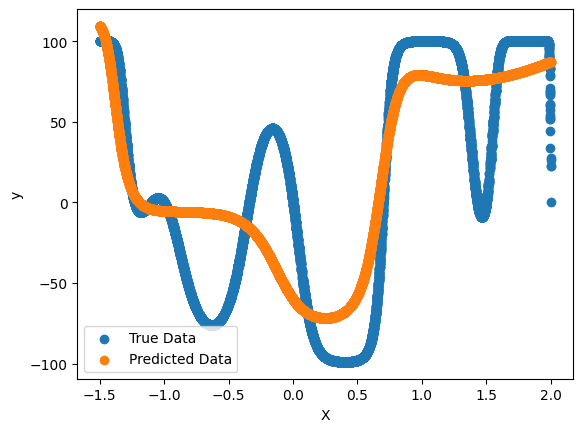

[1, 5, 5, 5, 1]


Training: 100%|██████████| 1000/1000 [01:10<00:00, 14.14it/s, loss=0.279377]


Best loss: 0.20940739617911258
MSE: 1084.1603377009455


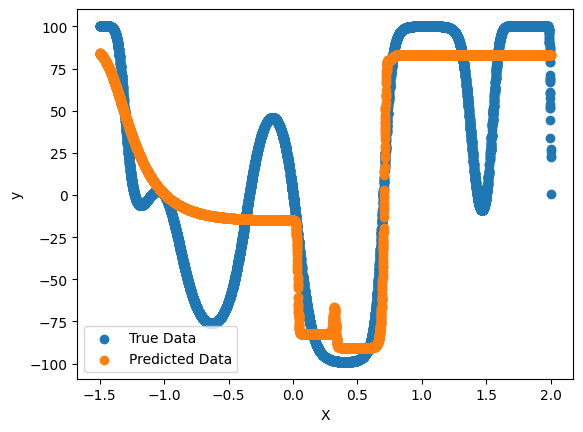

[1, 5, 10, 1]


Training: 100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s, loss=0.250453]


Best loss: 0.24370719529978
MSE: 1261.7399384039245


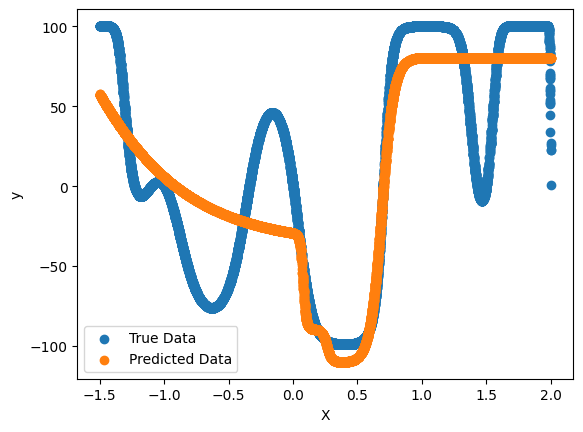

In [45]:
architectures = [
[1, 10, 10, 10, 1],
[1, 10, 10, 1],
[1, 5, 10, 5, 1],
[1, 5, 5, 5, 1],
[1, 5, 10, 1]
]

for architecture in architectures:
    print(architecture)
    NN = MLPBackprop(architecture, hidden_activation_function='sigmoid', output_activation_function='linear')
    NN.train(X_train_scaled, y_train_scaled, epochs=1000, learning_rate=0.1, batch_size=20)


    y_pred_scaled = NN.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
    print("MSE:", mse)

    plot_comparison(X_test, y_test, y_pred)

[1, 10, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s, loss=0.140016]


Best loss: 0.12256575353935263
MSE: 634.556998331321


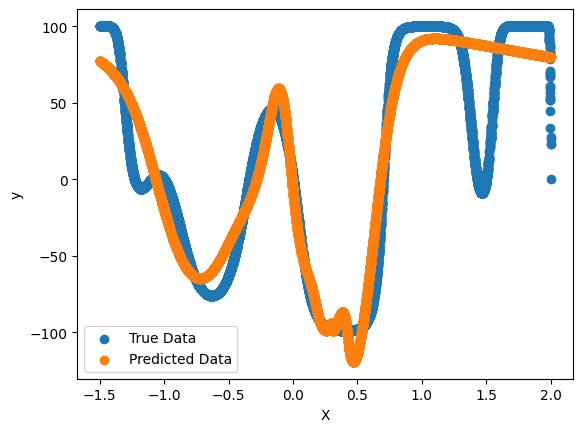

[1, 10, 10, 1]


Training: 100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s, loss=0.121458]


Best loss: 0.12025056834691145
MSE: 622.5706406100761


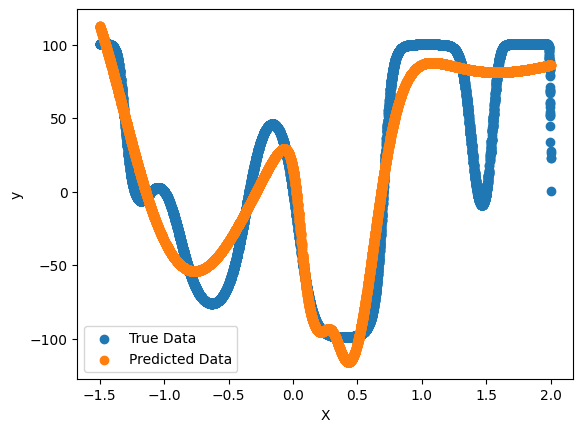

[1, 5, 10, 5, 1]


Training: 100%|██████████| 1000/1000 [01:14<00:00, 13.37it/s, loss=0.453993]


Best loss: 0.45120866458586445
MSE: 2336.0327624368647


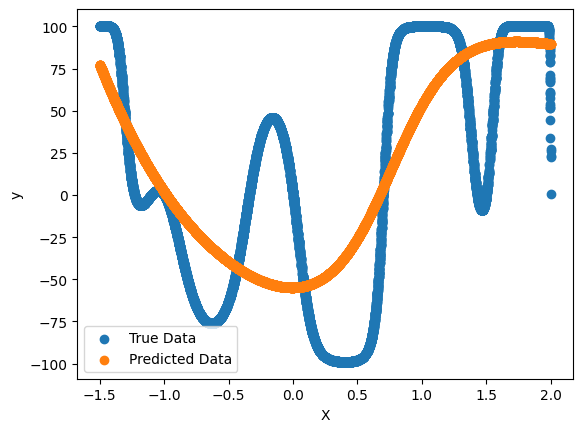

[1, 5, 5, 5, 1]


Training: 100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s, loss=0.507749]


Best loss: 0.5062652846463512
MSE: 2621.076198755585


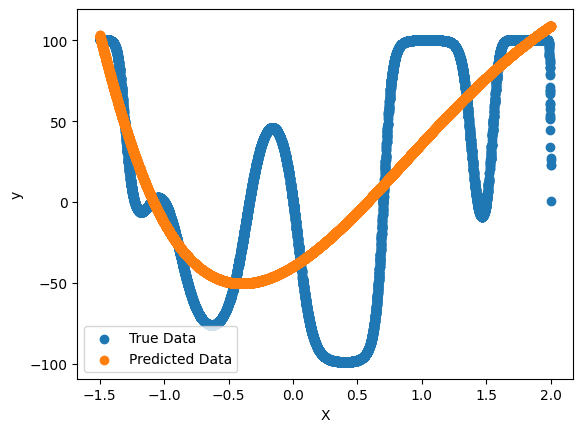

[1, 5, 10, 1]


Training: 100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s, loss=0.517466]


Best loss: 0.5103018636199491
MSE: 2641.974690895898


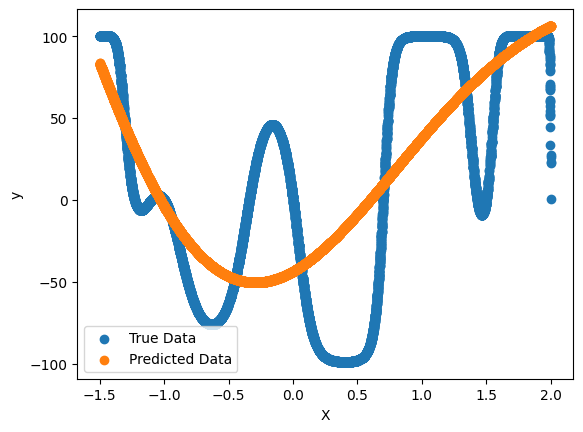

In [46]:
architectures = [
[1, 10, 10, 10, 1],
[1, 10, 10, 1],
[1, 5, 10, 5, 1],
[1, 5, 5, 5, 1],
[1, 5, 10, 1]
]

for architecture in architectures:
    print(architecture)
    NN = MLPBackprop(architecture, hidden_activation_function='sigmoid', output_activation_function='linear')
    NN.train(X_train_scaled, y_train_scaled, epochs=1000, learning_rate=0.01, batch_size=20)


    y_pred_scaled = NN.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
    print("MSE:", mse)

    plot_comparison(X_test, y_test, y_pred)

[1, 10, 10, 10, 1]


Training: 100%|██████████| 10000/10000 [24:02<00:00,  6.93it/s, loss=0.122778]


Best loss: 0.06576947879186837
MSE: 340.50688580463566


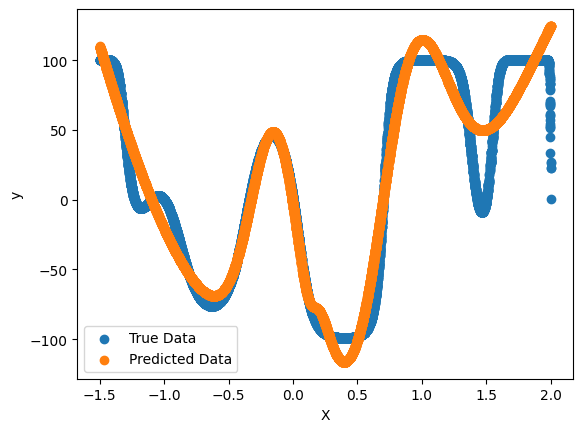

[1, 10, 10, 1]


Training: 100%|██████████| 10000/10000 [13:44<00:00, 12.14it/s, loss=0.062515]


Best loss: 0.05805982730303178
MSE: 300.59187557001917


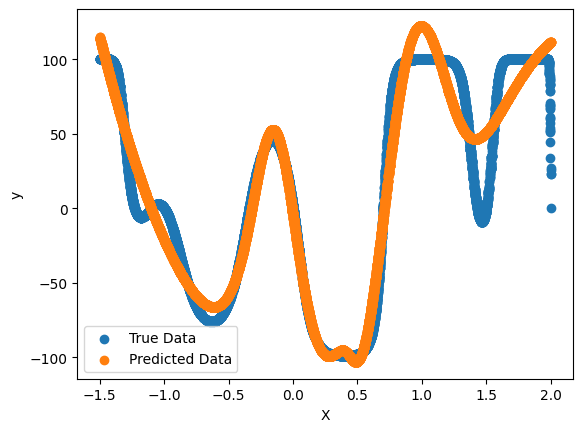

[1, 5, 10, 5, 1]


Training: 100%|██████████| 10000/10000 [21:12<00:00,  7.86it/s, loss=0.212945]


Best loss: 0.15190337048969754
MSE: 786.4460016835316


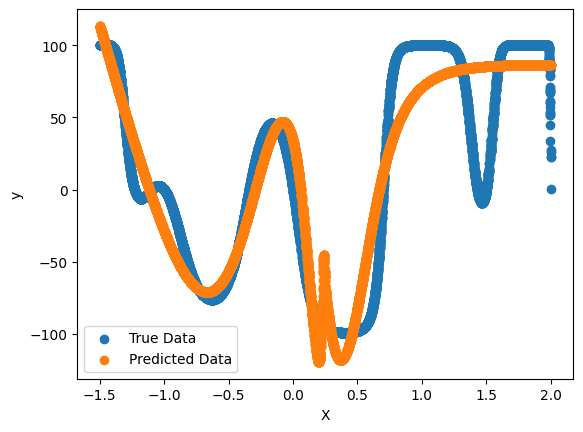

[1, 5, 5, 5, 1]


Training: 100%|██████████| 10000/10000 [17:52<00:00,  9.33it/s, loss=0.302949]


Best loss: 0.09057021158112168
MSE: 468.9071778985676


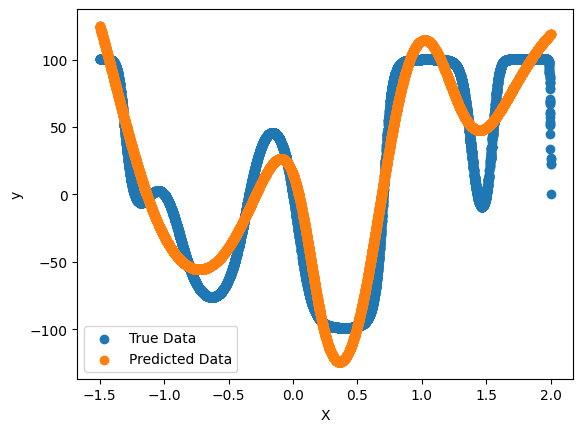

[1, 5, 10, 1]


Training: 100%|██████████| 10000/10000 [13:33<00:00, 12.29it/s, loss=0.240375]


Best loss: 0.11140454069092909
MSE: 576.7722948696102


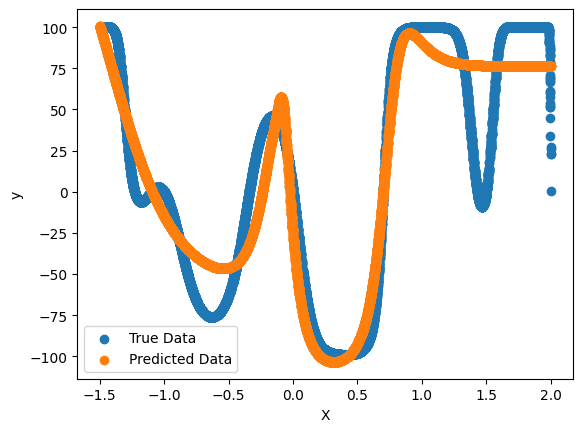

In [47]:
architectures = [
[1, 10, 10, 10, 1],
[1, 10, 10, 1],
[1, 5, 10, 5, 1],
[1, 5, 5, 5, 1],
[1, 5, 10, 1]
]

for architecture in architectures:
    print(architecture)
    NN = MLPBackprop(architecture, hidden_activation_function='sigmoid', output_activation_function='linear')
    NN.train(X_train_scaled, y_train_scaled, epochs=10000, learning_rate=0.01, batch_size=20)


    y_pred_scaled = NN.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
    print("MSE:", mse)

    plot_comparison(X_test, y_test, y_pred)